<a href="https://colab.research.google.com/github/deadshotbane80/learning_Micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [3]:
class Value:
  def __init__(self,data,children = (),op='',label=''):
    self.data = data
    self.label = label
    self.children = set(children)
    self.op = op
    self.grad = 0.0
    self.backward = lambda:None
  def __repr__(self):
    return f"Value({self.label} = {self.data})"
  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data,(self,other),op='*')
    def backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out.backward = backward
    return out
  def __rmul__(self,other):
    return self * other
  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),op='+')
    def backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out.backward = backward
    return out
  def __radd__(self,other):
    return self + other
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t,(self,),op='tanh')
    def backward():
      self.grad = (1 - t**2) * out.grad
    out.backward = backward
    return out
  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')
    def backward():
      self.grad = out.data * out.grad
    out.backward = backward
    return out
  def __neg__(self):
    return self * -1
  def __sub__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = self + (-other)
    return out
  def __rsub__(self,other):
    return self + -(other)
  def __pow__(self,other):
    assert isinstance(other,(int,float)),f"Power should be either int or float"
    out = Value(self.data**other,(self,),op=f'**{other}')
    def backward():
      self.grad = other * (self.data**(other-1)) * out.grad
    out.backward = backward
    return out
  def __truediv__(self,other):
    out = (self) * (other**-1)
    return out
  def __rtruediv__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    return other * self**-1
  def _backward(self):
    self.grad = 1.0
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.children:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    for n in reversed(topo):
      n.backward()

In [4]:
#inputs
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432,label = 'b')
#bias of the neuron
b = Value(6.8813735870195432,label = 'b')
x1w1 = x1*w1 ;x1w1.label = 'x1w1'
x2w2 = x2*w2 ;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
#--------------
e = (2*n).exp();e.label = 'e'
o = (e - 1)/(e + 1) ; o.label = 'o'
o._backward()
#--------------
# o = n.tanh();o.label = 'o'
# o._backward()

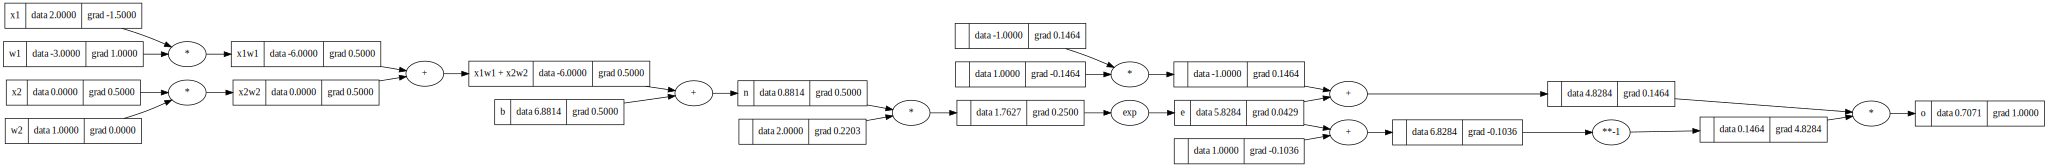

In [5]:
draw_dot(o)

In [92]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self,x):
    xw = sum(x1*w1 for w1,x1 in zip(self.w,x)) + self.b
    return xw
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.Neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    out = [n(x) for n in self.Neurons]
    return out[0] if len(out) == 1 else out
  def parameters(self):
    return [p for i in self.Neurons for p in i.parameters()]
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.Layers = [Layer(sz[i],sz[i+1]) for i in range(len(sz)-1)]
  def __call__(self,x):
    for n in self.Layers:
      x = n(x)
    return x
  def parameters(self):
    return [par for layer in self.Layers for par in layer.parameters()]




In [93]:
x = [2.0,1.0,3.0]
n = MLP(3,[4,4,1])
# n(x)

In [48]:
n(x)._backward()

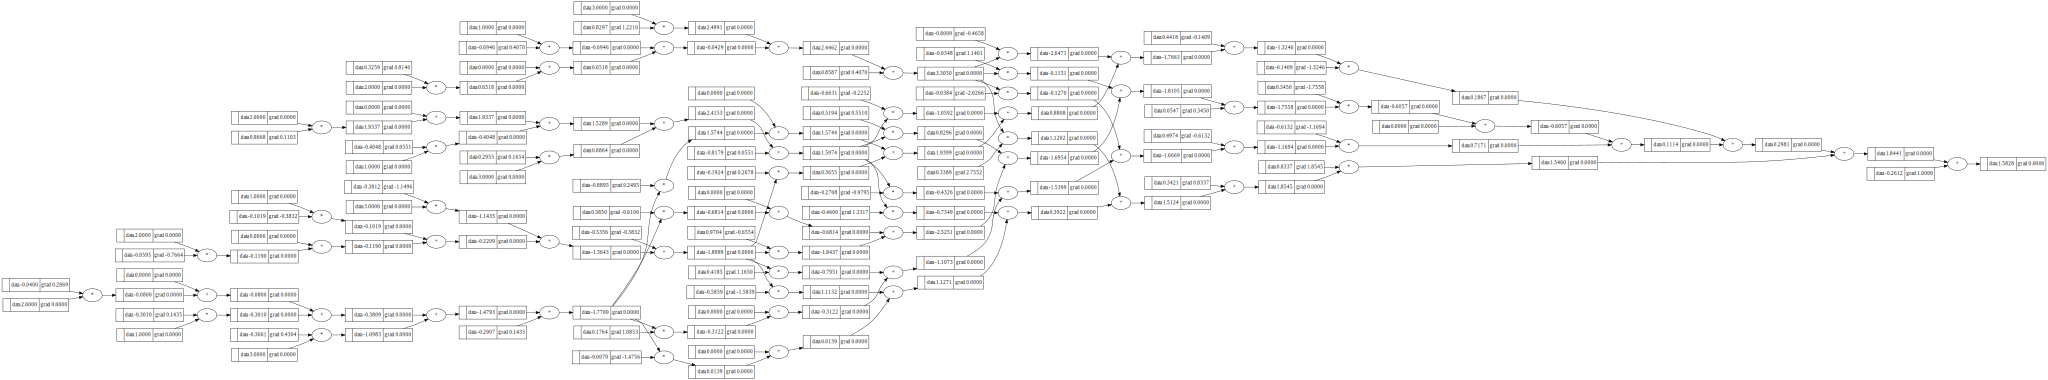

In [49]:
draw_dot(n(x))

In [94]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [95]:
ypred = [n(x) for x in xs]
ypred

[Value( = -1.921189337552974),
 Value( = -2.2008878913984202),
 Value( = -1.2430175961087697),
 Value( = -1.5702757433949708)]

In [96]:
loss= [(ygt-yout)**2 for ygt,yout in zip(ys,ypred)]
loss = sum(loss)
loss

Value( = 16.640853822643585)

In [98]:
len(n.parameters())

41

In [103]:
#Gradient Descent
for i in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss= sum((ygt-yout)**2 for ygt,yout in zip(ys,ypred))
  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss._backward()
  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  print(i,loss)


0 Value( = 0.10077690381055684)
1 Value( = 0.09532157175143227)
2 Value( = 0.09015100691347476)
3 Value( = 0.08524507892390534)
4 Value( = 0.08058765390892056)
5 Value( = 0.07616514830513446)
6 Value( = 0.07196565328529962)
7 Value( = 0.06797840362899142)
8 Value( = 0.06419345418163164)
9 Value( = 0.06060148127924135)
10 Value( = 0.057193659378575415)
11 Value( = 0.05396158298539028)
12 Value( = 0.05089721593120354)
13 Value( = 0.047992857231687516)
14 Value( = 0.045241117065159084)
15 Value( = 0.04263489898634691)
16 Value( = 0.04016738603170062)
17 Value( = 0.037832029294425376)
18 Value( = 0.0356225380997635)
19 Value( = 0.03353287124295577)


In [104]:
ypred

[Value( = 1.0962637778132982),
 Value( = -0.9769988677421996),
 Value( = -1.0501715588724427),
 Value( = 0.8543294164244685)]